## Part I: Parameters for individual simulations.

In [1]:
#General math tools and plotting tools.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

Loaded 513 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


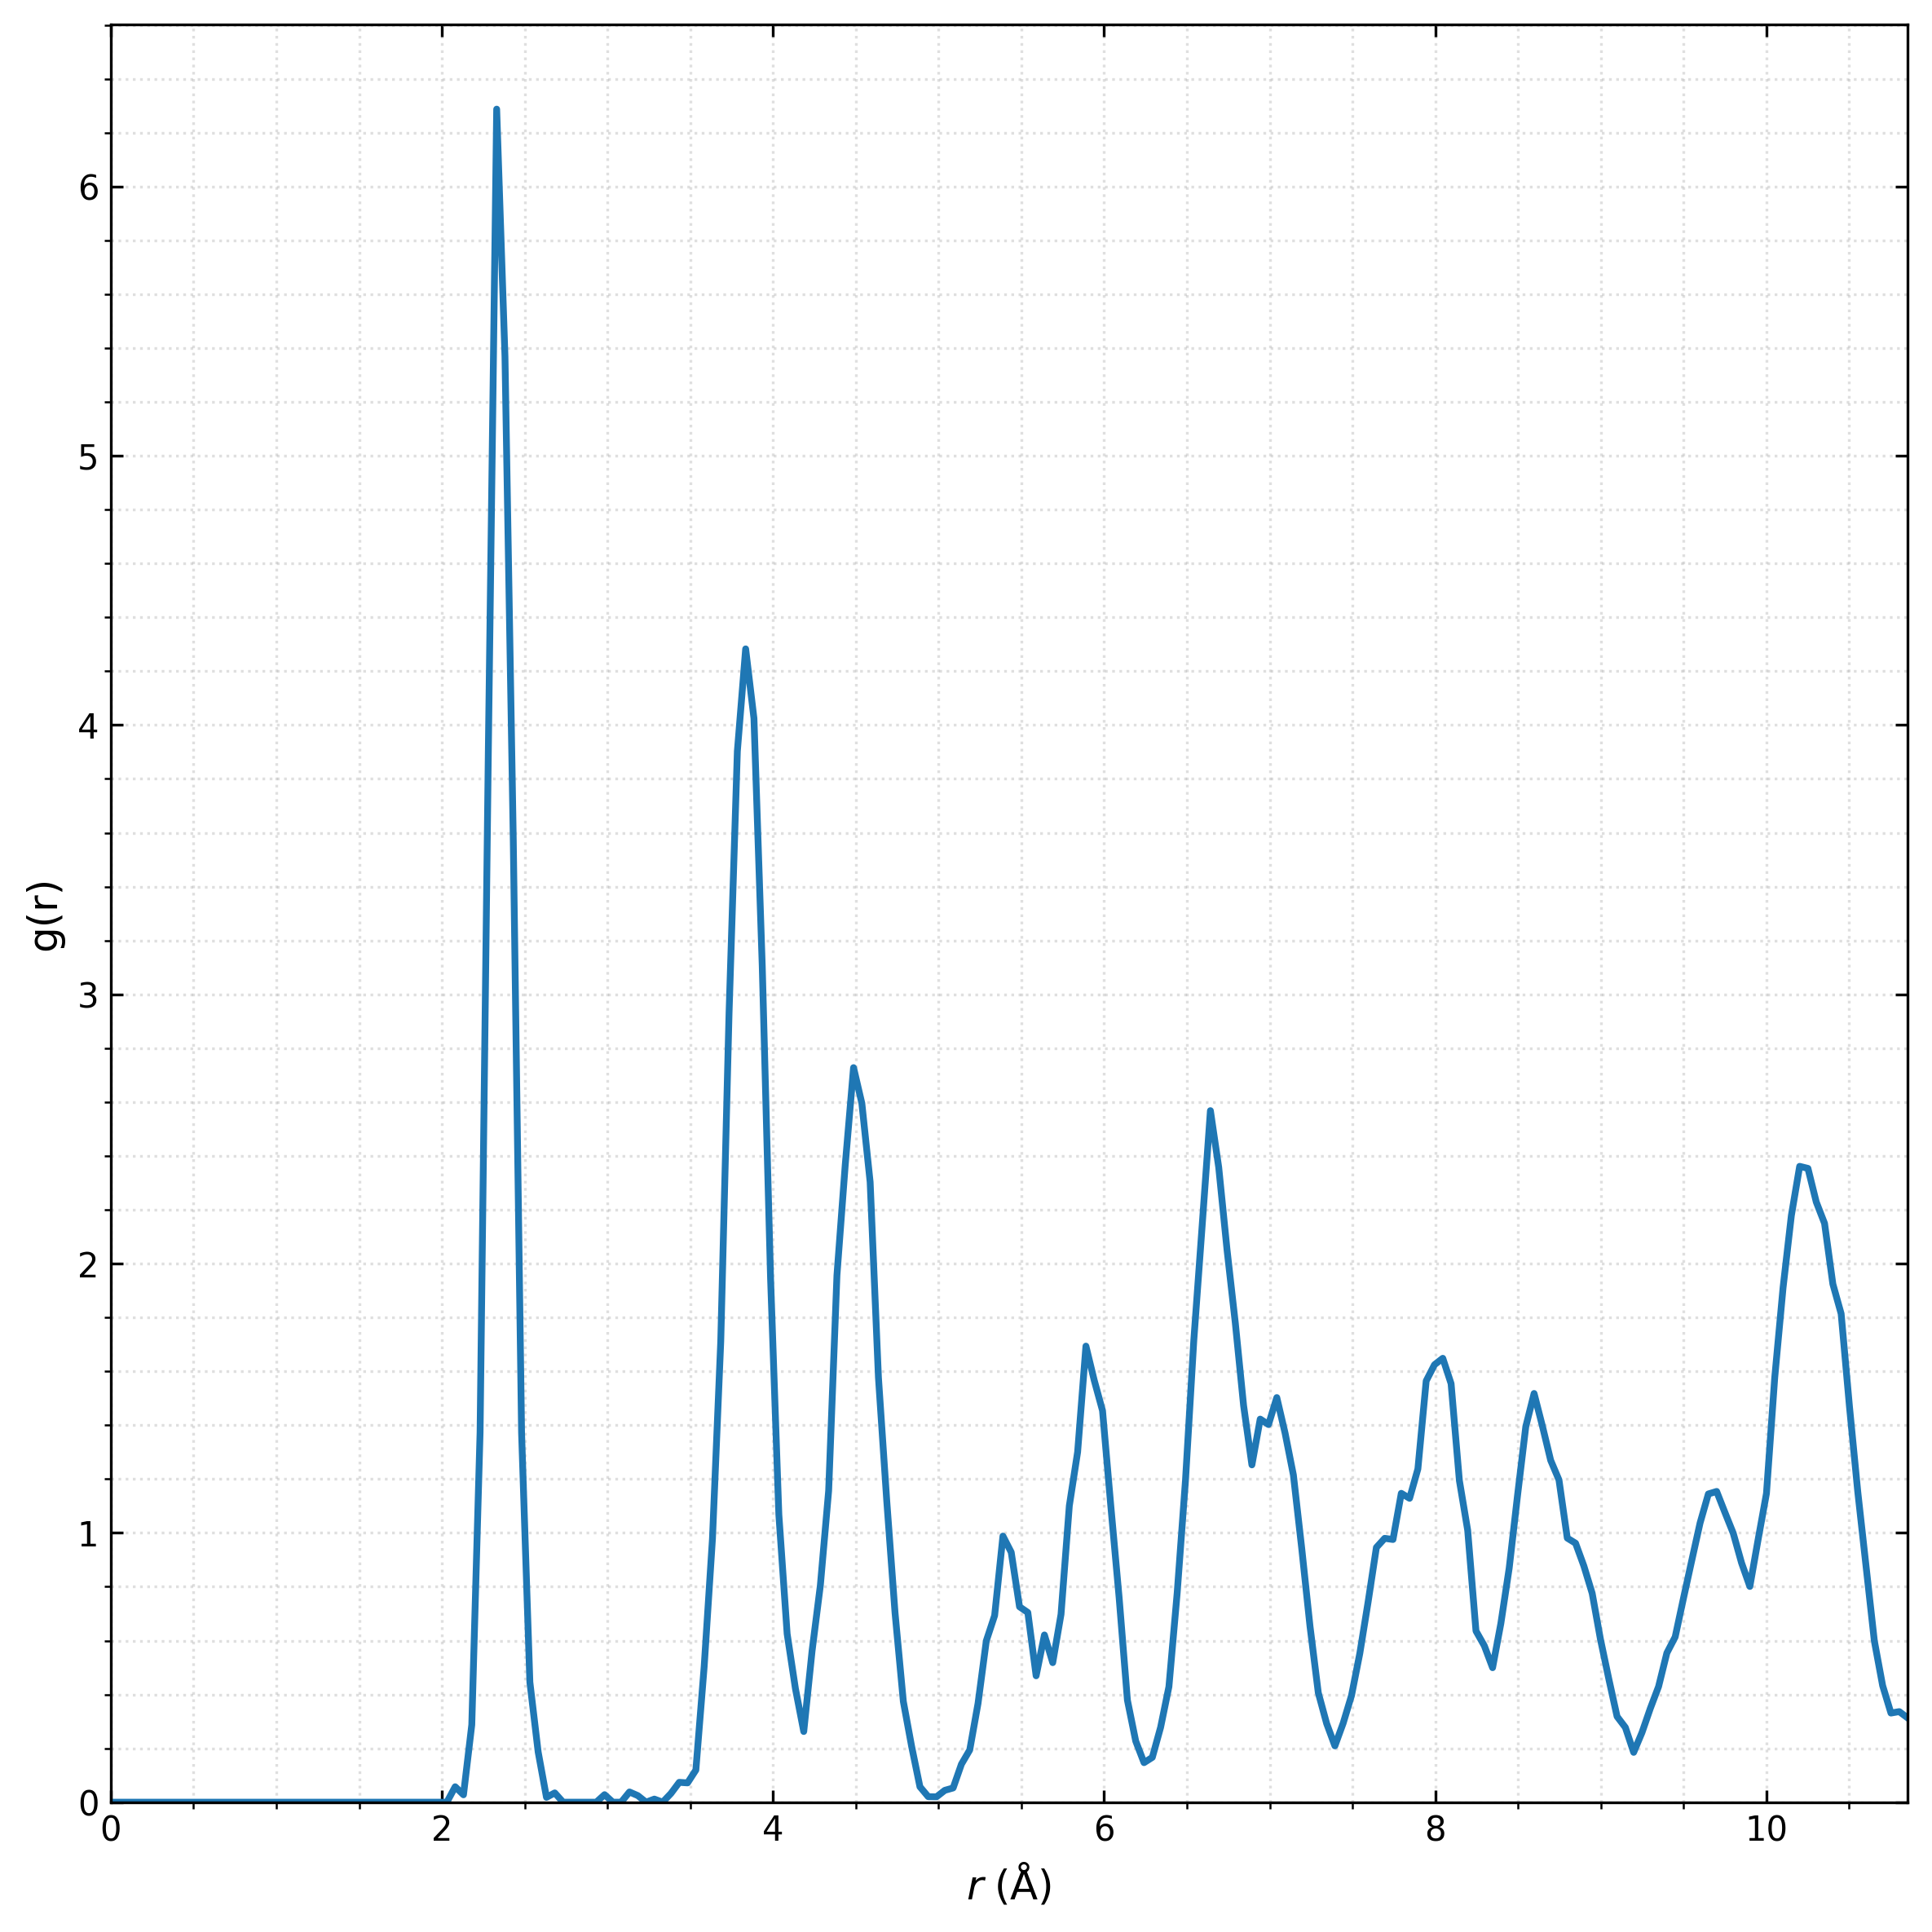

In [2]:
#Pair Correlation Function.

#Read LAMMPS file
def read_lammps_atomic_structure(filename):
    """
    Read the final structure with 'Atoms # atomic' and
    return positions (N, 3) and box length (Lx, Ly, Lz).
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()

    Lx = Ly = Lz = None
    atoms_start = None

    for i, line in enumerate(lines):
        if "xlo xhi" in line:
            a, b = line.split()[ : 2]
            Lx = float(b) - float(a)
        elif "ylo yhi" in line:
            a, b = line.split()[ : 2]
            Ly = float(b) - float(a)
        elif "zlo zhi" in line:
            a, b = line.split()[ : 2]
            Lz = float(b) - float(a)
        elif line.startswith("Atoms"):
            #Actual data starts third line.
            atoms_start = i + 2
            break
    
    positions = []
    for line in lines[atoms_start : ] :
        line = line.strip()
        if not line:
            break
        if line[0].isalpha():
            break
        parts = line.split()
        x, y, z = map(float, parts[2 : 5])
        positions.append([x, y, z])
    
    positions = np.array(positions, dtype = float)
    box = np.array([Lx, Ly, Lz], dtype = float)
    

    if atoms_start is None:
        raise RuntimeError("Hmmm, your simulation is not quite the same.")
    
    return positions, box

def compute_pair_correlation(positions, box, dr = 0.05, r_max = None):
    """
    Compute the pair correlation function g(r).
    Input: positions = (x, y, z); box = (Lx, Ly, Lz), dr = resolution, r_max = maximum length for 
    truncation, which is the half of the box side.

    Return the pair correlation for each atoms under considerations.
    """

    pos = np.array(positions, dtype = float)
    N = pos.shape[0]
    Lx, Ly, Lz = box
    volume = Lx * Ly * Lz
    rho = N / volume #Number density.
    #Set r_max by default:
    if r_max is None:
        r_max = 0.5 * min(box)
    
    nbins = int(r_max / dr)
    edges = np.linspace(0.0, r_max, nbins + 1)
    hist = np.zeros(nbins, dtype = float)
    #Distance between each particles.
    for i in range(N):
        d = pos - pos[i]
    #MIC
        d[:, 0] -= Lx * np.round(d[:, 0] / Lx)
        d[:, 1] -= Ly * np.round(d[:, 1] / Ly)
        d[:, 2] -= Lz * np.round(d[:, 2] / Lz)
        r = np.linalg.norm(d, axis = 1)
        #Truncations.
        cutoff = (r > 0.0) & (r < r_max)
        r_cutoff = r[cutoff]
        counts, _ = np.histogram(r_cutoff, bins = edges)
        hist += counts
    #Normalization
    g_r = np.zeros(nbins, dtype = float)
    for i in range (nbins):
        r_in = edges[i]
        r_out = edges[i + 1]
        shell_vol = (4.0 / 3.0) * np.pi * (r_out ** 3 - r_in ** 3)
        n_ideal = N * rho * shell_vol
        if n_ideal > 0:
            g_r[i] = hist[i] / n_ideal

    r_centers = 0.5 * (edges[: -1] + edges[1 :])
    return r_centers, g_r

def plot_helper(r, g_r, outfile = "700 K 1 Interstitial/Pair_Correlation.png"):
    fig, ax = plt.subplots(figsize = (8, 8), dpi = 300)
    ax.plot(r, g_r, linewidth = 2.0)
    ax.set_xlabel(r"$r \; (\mathrm{\AA})$", fontsize = 12)
    ax.set_ylabel(r"g(r)", fontsize = 12)
    #May change the title based on the simulation conditions.
    ax.set_xlim(0, r.max())
    ax.set_ylim(bottom = 0)
    ax.grid(True, which = "both", linestyle = ":", alpha = 0.4)
    ax.tick_params(direction = "in", top = True, right = True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    fig.tight_layout()
    fig.savefig(outfile, dpi = 300)
    plt.show()

def main():
    #Double check your files!
    data_file = "700 K 1 Interstitial/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")
    dr = 0.05
    r, g_r = compute_pair_correlation(positions, box, dr = dr)
    np.savetxt("700 K 1 Interstitial/gr.dat", np.column_stack((r, g_r)), header="r(Å)   g(r)   (FINAL_STRUCTURE)")
    plot_helper(r, g_r)

if __name__ == "__main__":
    main()

Loaded 513 atoms
Box (Å): Lx=21.7546, Ly=21.7546, Lz=21.7546


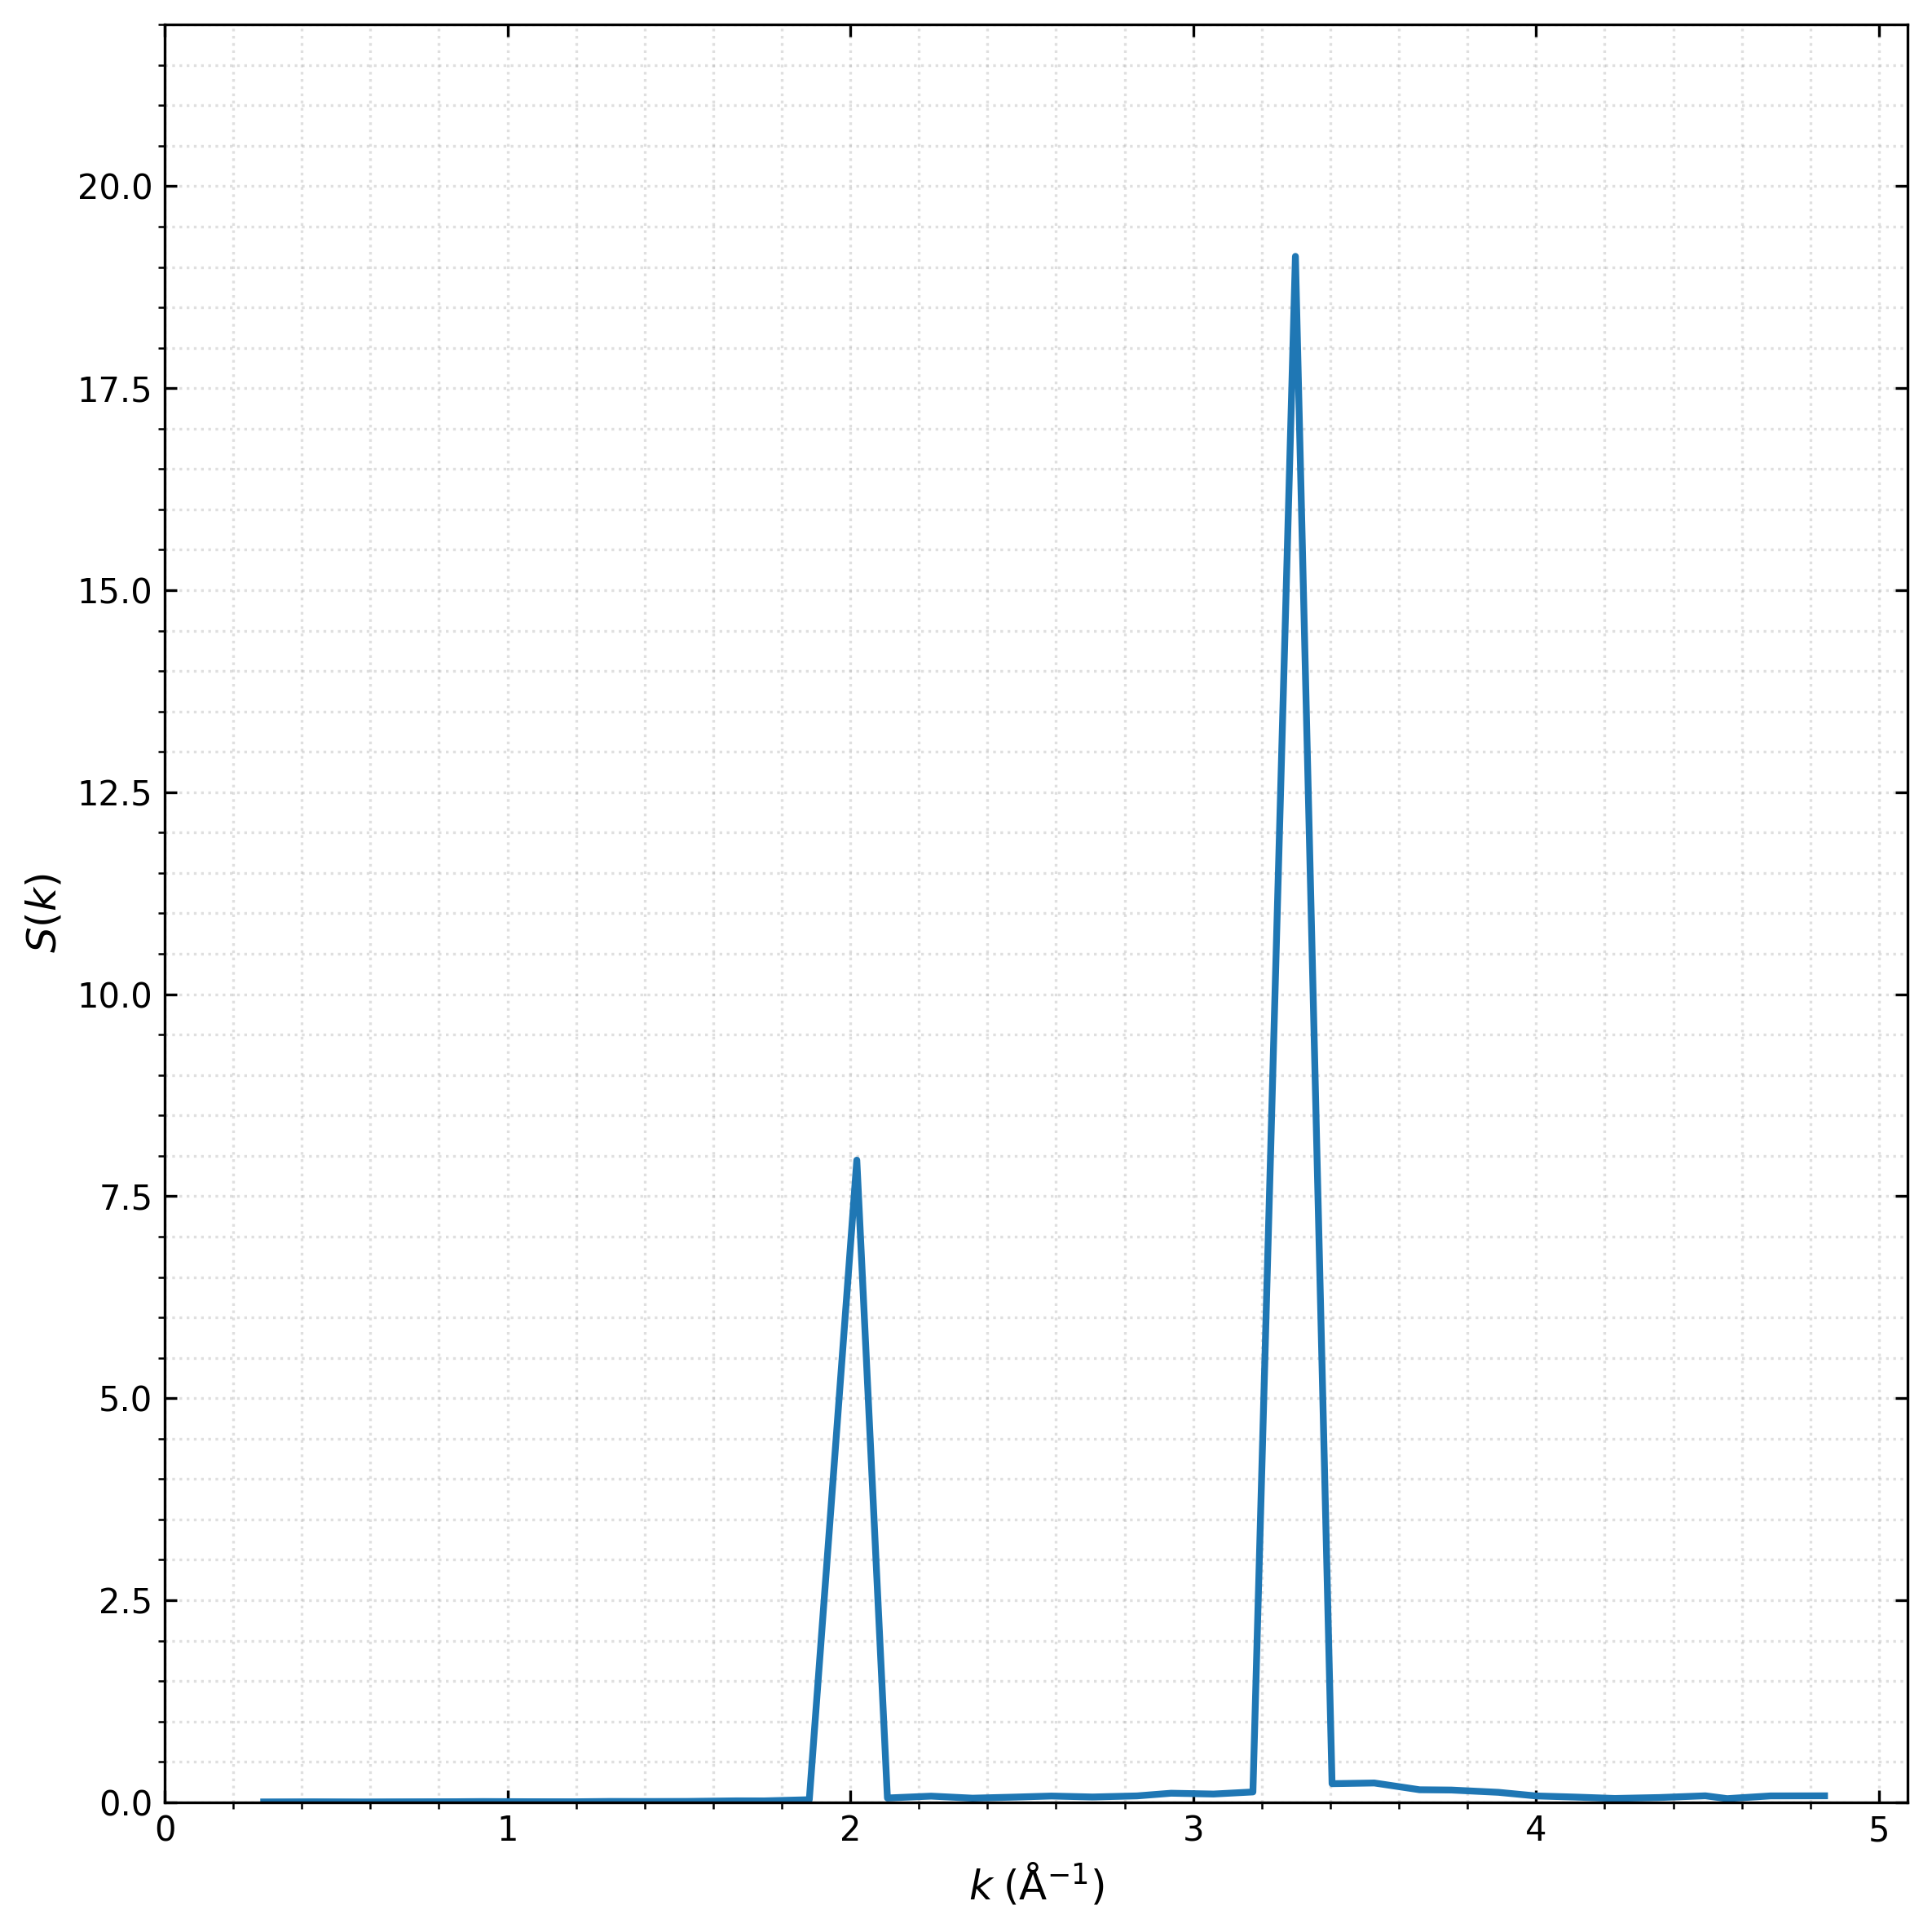

In [4]:
#Structural Factor S(K).
def legal_kvecs(maxn, L):
    """
    Generate k-vectors commensurate with the cubic box with size L.
    Only keep the all-positive octant.
    k = 2π/L * (nx, ny, nz); nx, ny, nz = 0, 1, 2, 3, ..., maxn. Set maxn = 10.
    """
    k0 = 2.0 * np.pi / float(L)
    n = np.arange(maxn + 1)
    nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")
    kvecs = np.column_stack([nx.ravel(), ny.ravel(), nz.ravel()])
    return k0 * kvecs

def calc_rhok(kvecs, pos):
    """
    ρ_k = Σ_j exp(-i k · r_j)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    phase = kvecs @ pos.T
    rhok = np.exp(-1j * phase).sum(axis = 1)
    return rhok

def calc_Sk(kvecs, pos):
    """
    S(k) = (1/N) ⟨ρ_k ρ_-k⟩ = |ρ_k|^2 / N  (single configuration)

    kvecs : (nk, 3)
    pos   : (N, 3)
    """
    N = pos.shape[0]
    rhok = calc_rhok(kvecs, pos)
    Sk = (rhok * np.conjugate(rhok)).real / N
    return Sk

def compute_structure_factor(positions, box, maxn_k = 10, k_cut = None, nbins_k = 40):
    """
    Compute S(K) in single configuration.
    """
    L = float(min(box))
    kvecs_all = legal_kvecs(maxn_k, L)
    k_mag_all = np.linalg.norm(kvecs_all, axis = 1)
    #Remove k = 0
    cutoff = k_mag_all > 0
    kvecs = kvecs_all[cutoff]
    k_mag = k_mag_all[cutoff]
    #In case to zoom in for comparison, change here.
    if k_cut is not None:
        cutoff2 = k_mag < k_cut
        kvecs = kvecs[cutoff2]
        k_mag = k_mag[cutoff2]
    
    Sk = calc_Sk(kvecs, positions)

    # Bin by |k| to get isotropic S(k)
    nbins = nbins_k
    kmin, kmax = k_mag.min(), k_mag.max()
    bins = np.linspace(kmin, kmax, nbins + 1)
    bin_idx = np.digitize(k_mag, bins) - 1
    k_bin_list, Sk_bin_list = [], []

    for ib in range(nbins):
        mask_b = bin_idx == ib
        if np.any(mask_b):
            k_bin_list.append(k_mag[mask_b].mean())
            Sk_bin_list.append(Sk[mask_b].mean())

    k_bin = np.array(k_bin_list)
    Sk_bin = np.array(Sk_bin_list)
    return k_bin, Sk_bin

def plot_Sk(k, Sk, outfile = "Structure_Factor.png"):
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    ax.plot(k, Sk, linewidth = 2.0)
    ax.set_xlabel(r"$k \; (\mathrm{\AA^{-1}})$", fontsize = 12)
    ax.set_ylabel(r"$S(k)$", fontsize = 12)
    ax.set_xlim(0, k.max() * 1.05)
    ax.set_ylim(0, Sk.max() * 1.15)
    ax.grid(True, which="both", linestyle=":", alpha=0.4)
    ax.tick_params(direction="in", top=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    fig.tight_layout()
    fig.savefig(outfile, dpi=300)
    plt.show()

def main_Sk():
    data_file = "700 K 1 Interstitial/FINAL_STRUCTURE"
    positions, box = read_lammps_atomic_structure(data_file)
    print(f"Loaded {positions.shape[0]} atoms")
    print(f"Box (Å): Lx={box[0]:.4f}, Ly={box[1]:.4f}, Lz={box[2]:.4f}")

    maxn_k = 10
    k_cut = None
    nbins_k = 40

    k_bin, Sk_bin = compute_structure_factor(
        positions, box, maxn_k=maxn_k, k_cut=k_cut, nbins_k=nbins_k
    )

    np.savetxt(
        "700 K 1 Interstitial/Sk.dat",
        np.column_stack((k_bin, Sk_bin)),
        header="k(1/Å)   S(k)   (FINAL_STRUCTURE)",
    )
    plot_Sk(k_bin, Sk_bin, outfile="700 K 1 Interstitial/Structure_Factor.png")


if __name__ == "__main__":
    main_Sk()
    


The state dump file is not implementable in Github.
Thus, this simulation is runned locally.
You can find the state dump file that used for simulation through here:

https://drive.google.com/drive/folders/1fgJZpy7AYIN3JVe31-nMkF4hMQ0u-uv9

However, note that for each conditions, you need to mannually run the simulation again for repeating data analysis.

In [ ]:
#This is a code that helps you check whether your state dump file is
#ok on your own computer.

#It is not runned on Github, but your local codespace.

#If it is implementable, it returns True.

#Now it is False because we are in codespace on Github.

import os


dump_file = os.path.expanduser(
    "~/Downloads/LAMMPS_SIMULATION_485_1vac_1000K/state_dump"
)

print("dump_file =", dump_file)
print("exists?   =", os.path.exists(dump_file))

dump_file = /home/codespace/Downloads/LAMMPS_SIMULATION_485_1vac_1000K/state_dump
exists?   = False


In [ ]:
#Diffusion Coefficient of Si atoms by MSD.
#Note that this needs to be done in your own device.

#CHANGE THIS.
dump_path = "/Users/YOURNAME/Downloads/YOUR_SIMULATION_RESULT_FOLDER/state_dump"
natoms = 511 #Change based on simulation type.
timestep_ps = 0.001
fit_tmin_ps = 2 #Avoid Ballistic regime, can be adjusted.
fit_tmax_ps = None #Use the full tail, can be adjusted.

def compute_msd_from_dump(path, natoms, timestep_ps):
    times_ps = []
    msd_vals = []
    
    with open(path, "r") as f:
        frame_index = 0
        r0_unwrap = None
        rprev_unwrap = None
        rprev_wrapped = None
        L = None  

        while True:
            line = f.readline()
            if not line:
                break 

            if not line.startswith("ITEM: TIMESTEP"):
                raise RuntimeError("Unexpected file format; expected 'ITEM: TIMESTEP'")

            
            step = int(f.readline().strip())

            line = f.readline().strip()
            if not line.startswith("ITEM: NUMBER OF ATOMS"):
                raise RuntimeError("Expected 'ITEM: NUMBER OF ATOMS'")
            n = int(f.readline().strip())
            if n != natoms:
                raise RuntimeError(f"Expected {natoms} atoms, got {n}")

            line = f.readline().strip()
            if not line.startswith("ITEM: BOX BOUNDS"):
                raise RuntimeError("Expected 'ITEM: BOX BOUNDS'")
            bounds = []
            for _ in range(3):
                parts = f.readline().split()
                bounds.append((float(parts[0]), float(parts[1])))
            Lx, Ly, Lz = [hi - lo for lo, hi in bounds]
            if L is None:
                L = np.array([Lx, Ly, Lz])

            header = f.readline().split()
            if header[0] != "ITEM:" or header[1] != "ATOMS":
                raise RuntimeError("Expected 'ITEM: ATOMS' header")
            labels = header[2:]

            ix = labels.index("x")
            iy = labels.index("y")
            iz = labels.index("z")
            id_idx = labels.index("id") if "id" in labels else None

            coords_wrapped = np.zeros((natoms, 3), float)
            for i in range(n):
                cols = f.readline().split()
                atom_id = int(cols[id_idx]) - 1 if id_idx is not None else i
                coords_wrapped[atom_id, 0] = float(cols[ix])
                coords_wrapped[atom_id, 1] = float(cols[iy])
                coords_wrapped[atom_id, 2] = float(cols[iz])

            if frame_index == 0:
                rprev_wrapped = coords_wrapped.copy()
                rprev_unwrap  = coords_wrapped.copy()
                r0_unwrap     = coords_wrapped.copy()
            else:

                delta = coords_wrapped - rprev_wrapped
                for dim, Ldim in enumerate(L):
                    mask_pos = delta[:, dim] >  0.5 * Ldim
                    mask_neg = delta[:, dim] < -0.5 * Ldim
                    delta[mask_pos, dim] -= Ldim
                    delta[mask_neg, dim] += Ldim

                rcurr_unwrap   = rprev_unwrap + delta
                rprev_unwrap   = rcurr_unwrap
                rprev_wrapped  = coords_wrapped

            r_use = rprev_unwrap if frame_index > 0 else r0_unwrap

            dr       = r_use - r0_unwrap
            msd_val  = np.mean(np.sum(dr**2, axis=1))
            time_ps  = step * timestep_ps

            times_ps.append(time_ps)
            msd_vals.append(msd_val)

            frame_index += 1

    return np.array(times_ps), np.array(msd_vals)

def fit_diffusion(times_ps, msd, tmin_ps, tmax_ps=None):
    if tmax_ps is None:
        tmax_ps = times_ps[-1]
    mask = (times_ps >= tmin_ps) & (times_ps <= tmax_ps)

    t_fit   = times_ps[mask]
    msd_fit = msd[mask]

    # linear fit: MSD = a * t + b
    a, b = np.polyfit(t_fit, msd_fit, 1)

    D_A2_per_ps = a / 6.0           # Einstein relation in 3D
    D_m2_per_s  = D_A2_per_ps * 1e-8  # 1 Å^2/ps = 1e-8 m^2/s

    return a, b, D_A2_per_ps, D_m2_per_s, t_fit

print("Reading dump and computing MSD...")
times_ps, msd = compute_msd_from_dump(dump_path, natoms, timestep_ps)
print(f"Read {len(times_ps)} frames; total time ≈ {times_ps[-1]:.2f} ps")

a, b, D_A2_ps, D_m2_s, t_fit = fit_diffusion(times_ps, msd, fit_tmin_ps, fit_tmax_ps)

print(f"Slope a (MSD vs t) = {a:.4e} Å^2/ps")
print(f"D = {D_A2_ps:.4e} Å^2/ps")
print(f"  = {D_m2_s:.4e} m^2/s")

# Plot
plt.figure()
plt.plot(times_ps, msd, label="MSD (all data)")
plt.plot(t_fit, a * t_fit + b, "--", label="Linear fit region")
plt.xlabel("t (ps)")
plt.ylabel(r"MSD (Å$^2$)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Compute D through Hopping.

import numpy as np

dump_path = "/Users/YOURNAME/Downloads/YOUR_FILE_FOR_SIMULATION/state_dump"
timestep_ps = 0.001
hop_threshold_A = 1.0
#For vibration, the maximum is around 0.8, so 1.0 is pretty good.   

dead_frames = 3

jump_distance_A = 2.35


def analyze_hops_from_dump(path, timestep_ps, hop_threshold_A, dead_frames):
    """
    Reads a LAMMPS dump file, unwraps coordinates, and counts hops.

    Returns
    -------
    natoms : int
    total_hops : int
    total_time_ps : float
    """

    with open(path, "r") as f:
        frame_idx = 0
        natoms = None
        rprev_wrap = None
        rprev_unwrap = None
        last_hop_frame = None
        L = None
        first_step = None
        last_step = None

        while True:
            line = f.readline()
            if not line:
                break  

            if not line.startswith("ITEM: TIMESTEP"):
                raise RuntimeError(f"Expected 'ITEM: TIMESTEP', got: {line.strip()}")

            step = int(f.readline().strip())
            if first_step is None:
                first_step = step
            last_step = step

            line = f.readline().strip()
            if not line.startswith("ITEM: NUMBER OF ATOMS"):
                raise RuntimeError("Expected 'ITEM: NUMBER OF ATOMS'")
            n = int(f.readline().strip())
            if natoms is None:
                natoms = n
            elif n != natoms:
                raise RuntimeError(f"Inconsistent natoms: previously {natoms}, now {n}")

            line = f.readline().strip()
            if not line.startswith("ITEM: BOX BOUNDS"):
                raise RuntimeError("Expected 'ITEM: BOX BOUNDS'")
            bounds = []
            for _ in range(3):
                parts = f.readline().split()
                bounds.append((float(parts[0]), float(parts[1])))
            Lx, Ly, Lz = [hi - lo for lo, hi in bounds]
            if L is None:
                L = np.array([Lx, Ly, Lz])

            # atoms header
            header = f.readline().split()
            if header[0] != "ITEM:" or header[1] != "ATOMS":
                raise RuntimeError("Expected 'ITEM: ATOMS' header")
            labels = header[2:]

            try:
                ix = labels.index("x")
                iy = labels.index("y")
                iz = labels.index("z")
            except ValueError:
                raise RuntimeError("Dump must contain x y z columns")

            id_idx = labels.index("id") if "id" in labels else None

            coords_wrapped = np.zeros((natoms, 3), float)
            for i in range(n):
                cols = f.readline().split()
                atom_id = int(cols[id_idx]) - 1 if id_idx is not None else i
                coords_wrapped[atom_id, 0] = float(cols[ix])
                coords_wrapped[atom_id, 1] = float(cols[iy])
                coords_wrapped[atom_id, 2] = float(cols[iz])

            if frame_idx == 0:
                
                rprev_wrap = coords_wrapped.copy()
                rprev_unwrap = coords_wrapped.copy()
                last_hop_frame = -np.ones(natoms, dtype=int)
                total_hops = 0
            else:
                delta = coords_wrapped - rprev_wrap  
                for dim, Ldim in enumerate(L):
                    big_pos = delta[:, dim] >  0.5 * Ldim
                    big_neg = delta[:, dim] < -0.5 * Ldim
                    delta[big_pos, dim] -= Ldim
                    delta[big_neg, dim] += Ldim
                rcurr_unwrap = rprev_unwrap + delta

                dr = rcurr_unwrap - rprev_unwrap
                dr_mag = np.linalg.norm(dr, axis=1)

                candidates = dr_mag >= hop_threshold_A
                can_hop = (frame_idx - last_hop_frame) > dead_frames
                new_hops = candidates & can_hop

                nhops_this_frame = np.count_nonzero(new_hops)
                total_hops += nhops_this_frame
                last_hop_frame[new_hops] = frame_idx
                rprev_wrap = coords_wrapped
                rprev_unwrap = rcurr_unwrap

            frame_idx += 1

    total_time_ps = (last_step - first_step) * timestep_ps
    return natoms, total_hops, total_time_ps


natoms, total_hops, total_time_ps = analyze_hops_from_dump(
    dump_path,
    timestep_ps=timestep_ps,
    hop_threshold_A=hop_threshold_A,
    dead_frames=dead_frames,
)

print(f"Atoms        : {natoms}")
print(f"Total hops   : {total_hops}")
print(f"Total time   : {total_time_ps:.2f} ps")

if total_hops == 0:
    print("No hops detected with this threshold; try lowering hop_threshold_A.")
else:
    
    T_s = total_time_ps * 1e-12                
    a2_A2 = jump_distance_A ** 2              
    D_A2_per_ps = a2_A2 * total_hops / (6.0 * natoms * total_time_ps)
    D_m2_per_s = (jump_distance_A * 1e-10) ** 2 * total_hops / (6.0 * natoms * T_s)

    print(f"Estimated D (hop-based) = {D_A2_per_ps:.4e} Å^2/ps")
    print(f"                         = {D_m2_per_s:.4e} m^2/s")

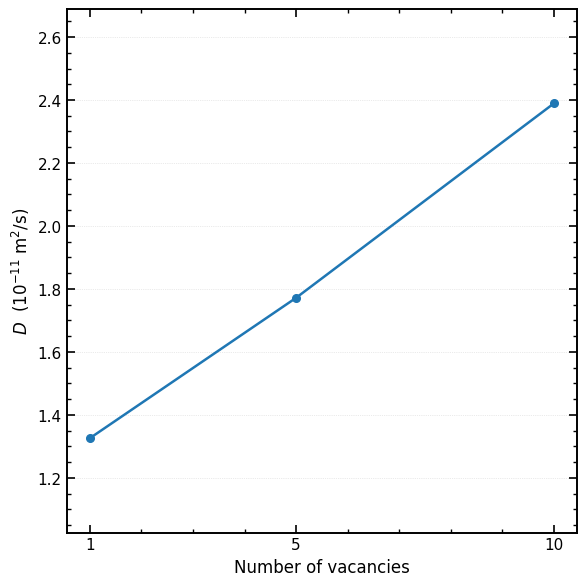

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_vac = np.array([1, 5, 10])
D = np.array([1.3262e-11, 1.7718e-11, 2.3890e-11]) 
D_scaled = D / 1e-11   

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 11,
    "axes.linewidth": 1.4,
})

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(
    n_vac,
    D_scaled,
    marker="o",
    markersize=5.5,
    linewidth=1.8,
    linestyle="-",
)

ax.set_xlabel("Number of vacancies", fontsize=12)
ax.set_ylabel(r"$D$  ($10^{-11}$ m$^2$/s)", fontsize=12)

ax.set_xticks(n_vac)
ax.tick_params(axis="both", which="major",
               direction="in", length=6, width=1.2,
               top=True, right=True)
ax.tick_params(axis="both", which="minor",
               direction="in", length=3, width=1.0,
               top=True, right=True)

ax.minorticks_on()

ymin = D_scaled.min() - 0.3
ymax = D_scaled.max() + 0.3
ax.set_ylim(ymin, ymax)

ax.grid(axis="y", which="major", linestyle=":", linewidth=0.5, alpha=0.5)

fig.tight_layout()

plt.show()

